In [1]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import optuna
from joblib import Parallel, delayed
from utils.Loader import NEUDataset
from utils.Perspectiver import Perspectiver
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import multiprocessing
import torch
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_wavelet
import random
import math
from PIL import Image
from collections import deque
import numpy as np
from scipy.ndimage import maximum_filter, minimum_filter, label, generate_binary_structure
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.ndimage import label as ndi_label, binary_dilation

/home/lingfeng/Desktop/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def move(initial_pos, direction): return tuple(a + b for a, b in zip(initial_pos, direction))

def _get_area_groups(walker, positions:set, directions, record: set):
    next_moves = set()
    for dir in directions:
        next_pos = move(walker,directions[dir])
        if ( (next_pos in positions) and (next_pos not in (record)) ) :
            record.add(next_pos)
            next_moves.add(next_pos)
    if len(next_moves) == 0:
        record.add(walker)
    for next in next_moves:
        #print(next)
        walker = next
        record = record | _get_area_groups(walker, positions, directions, record)
    return record

def get_pits (cluster, maxcol: int, maxrow: int, previus_pits, previus_hills):
    pits = previus_pits
    hills = previus_hills
    directions={"right": (1,0), "left": (-1,0), "down":(0,1), "up":(0,-1)}
    #print(f"Tamaño: {len(cluster)}")
    while len(cluster) != 0:

        walker = cluster[0]
        #print(f"walker: {(walker)}")
        group  = _get_area_groups(walker=walker, positions=cluster, directions=directions, record=set())
        isValid = True

        for coordinate in group:
            if ( (0 in coordinate) or 
                 ( (maxrow-1) == np.array(coordinate)[0] ) or
                 ( (maxcol-1) == np.array(coordinate)[1] ) ): #Border cluster
                isValid=False
                break
            else: #Hay que comprobar que no es vecino fosas anteriormente reconocidas
                if previus_pits is not None:
                    for prev_pit in previus_pits:
                        for dir in directions:
                            if move(coordinate, directions[dir]) in prev_pit: 
                                isValid=False
                                break
                elif previus_hills is not None:
                    for prev_hill in previus_hills:
                        for dir in directions:
                            if move(coordinate, directions[dir]) in prev_hill: 
                                isValid=False
                                break

        #print(f"Tamaño antes de quitar un area: {len(cluster)}")
        cluster = [x for x in cluster if x not in group]

        #print(f"Tamaño despues: {len(cluster)}")
        if isValid: pits.append(group)
        else: hills.append(group)
        #print(pits)
    return pits, hills
            
def get_mean_pit_area(image):
    pixels = np.uint8(np.round(Perspectiver.rgb_to_grayscale(Perspectiver.normalize_to_uint8(image))))
    #pixels = image
    clusters = np.sort(np.unique(pixels))
    #print(f"Formato de la imagen: {image.shape}, clusters : {clusters}")

    pits = []
    hills = []

    MAXROW, MAXCOL = pixels.shape
    for cluster in clusters:

        #print(f"Altura del cluster: {cluster}")
        
        rows, cols = np.where(pixels == cluster)

        positions = list(zip(rows, cols))

        pits, hills = get_pits(positions, maxcol=MAXCOL, maxrow=MAXROW, previus_pits=pits, previus_hills=hills)

    area = sum([len(pit) for pit in pits])
    return area/len(pits)

In [3]:
import cv2
import numpy as np

def get_mean_pit_area_superfast(image):
    """
    Procesa de manera determinista los grupos conectados, 
    ordenándolos de abajo hacia arriba (fila descendente) 
    y columna ascendente.
    """
    # Convertimos la imagen a escala de grises normalizada
    pixels = np.uint8(
        np.round(
            Perspectiver.rgb_to_grayscale(
                Perspectiver.normalize_to_uint8(image)
            )
        )
    )

    maxrow, maxcol = pixels.shape
    clusters = np.sort(np.unique(pixels))

    pits, hills = [], []
    pits_union, hills_union = set(), set()

    # Direcciones para comprobar contigüidad y adyacencia
    directions = [(1,0), (-1,0), (0,1), (0,-1)]

    # Recolectamos todos los grupos conectados
    all_groups = []
    for cluster in clusters:
        mask = (pixels == cluster).astype(np.uint8)
        nlabels, labels = cv2.connectedComponents(mask, connectivity=4)

        for lbl_idx in range(1, nlabels):
            coords = np.argwhere(labels == lbl_idx)
            group_set = set(map(tuple, coords))
            # Coordenada mínima de la región (en filas y columnas)
            min_coord = coords.min(axis=0)  # (min_row, min_col)
            
            # Guardamos (min_coord, set_de_pixeles, cluster) 
            all_groups.append((tuple(min_coord), group_set, cluster))

    # Ahora ordenamos de ABAJO hacia ARRIBA => 
    # orden por -min_row. Para columnas, a menudo se deja en ascendente.
    # Cambiar a -min_col si se desea invertir también la columna.
    all_groups.sort(key=lambda x: (-x[0][0], x[0][1]))

    # Clasificación determinista de cada grupo (pits o hills)
    for _, group_set, _ in all_groups:
        is_valid = True
        for (gx, gy) in group_set:
            # Si toca borde, es hill
            if gx == 0 or gx == (maxrow - 1) or gy == 0 or gy == (maxcol - 1):
                is_valid = False
                break
            # Si está adyacente a grupos ya clasificados
            for dx, dy in directions:
                nx, ny = gx + dx, gy + dy
                if (nx, ny) in pits_union or (nx, ny) in hills_union:
                    is_valid = False
                    break
            if not is_valid:
                break

        # Asignamos según resultado
        if is_valid:
            pits.append(group_set)
            pits_union.update(group_set)
        else:
            hills.append(group_set)
            hills_union.update(group_set)

    # Área promedio de fosas
    if len(pits) == 0:
        return 0
    total_area = sum(len(p) for p in pits)
    return total_area #/ len(pits)


In [4]:
dataset = NEUDataset(set="train", transform=None, seed=1, scale=0.5)

# Probar con un DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Intentar iterar sobre el dataloader
for images, labels in dataloader:
    print("Iteración exitosa.")
    print("Imagen shape:", images.shape)
    print("Etiqueta shape:", labels.shape)
    break 

Iteración exitosa.
Imagen shape: torch.Size([4, 1, 100, 100])
Etiqueta shape: torch.Size([4, 6])


In [5]:
image, label = dataset.__getitem__(index=random.randint(2, len(dataset)))

'''
image = Image.open("metal_dataset/test/Pitted/PS_108.bmp")
original_width, original_height = image.size
scale = 0.5
image = image.resize((max(1, int(original_width * scale)), max(1, int(original_height * scale))))
original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(np.array(image)))
'''
original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(image.detach().cpu().numpy()[0]))

In [6]:
image = Image.open("metal_dataset/valid/Inclusion/In_111.bmp")
original_width, original_height = image.size
scale = 0.5
image = image.resize((max(1, int(original_width * scale)), max(1, int(original_height * scale))))
original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(np.array(image)))

In [7]:
def optimize_image(image, n_tries: int = 100):
    """
    Optimizes the mean shift parameters to maximize the metric: (Silhouette Score / Number of Clusters).

    Args:
        image (np.array): The input image with shape (200, 200, 3).
        n_tries (int): The number of optimization trials to run.

    Returns:
        dict: The best parameters and the best score.
    """

    # Define the objective function for Optuna
    def objective(trial):
        # Suggest parameters for spatial radius and color radius
        sp = trial.suggest_float("sp", 1.0, 50.0)  # Spatial window radius
        sr = trial.suggest_float("sr", 1.0, 50.0)  # Color window radius
        k = trial.suggest_int("k", 2, 30.0)
        # Apply mean shift filtering
        after = Perspectiver.kmeansClustering(Perspectiver.meanShift(image, sp, sr), k=k)

        return get_mean_pit_area_superfast(after)

    # Determine the number of CPU threads
    n_jobs = multiprocessing.cpu_count()-2
    print(f"Using {n_jobs} CPU threads for parallel optimization.")

    # Run the optimization with parallel trials
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_tries, n_jobs=n_jobs)

    # Return the best parameters and the best score
    return {
        "best_params": study.best_params,
        "best_score": study.best_value
    }

In [8]:
def plot_barchartImage(image):
    x = np.arange(image.shape[0])
    y = np.arange(image.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten arrays for plotting
    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)
    dx = dy = np.ones_like(x)
    dz = image.flatten()

    # Plot the 3D bar chart
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d(x, y, z, dx, dy, dz, shade=True)

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')
    ax.set_title('3D Bar Chart of (200, 200) Array')

    plt.show()

In [9]:
BEST = optimize_image(original_image, n_tries=800)["best_params"]
BEST

[I 2025-02-05 19:58:11,567] A new study created in memory with name: no-name-4f7d35d0-4918-416f-8524-004d5353c12a


Using 6 CPU threads for parallel optimization.


[I 2025-02-05 19:58:11,718] Trial 1 finished with value: 156.0 and parameters: {'sp': 1.7765960376512946, 'sr': 26.24527785157513, 'k': 2}. Best is trial 1 with value: 156.0.
[I 2025-02-05 19:58:12,145] Trial 3 finished with value: 181.0 and parameters: {'sp': 32.50334174029583, 'sr': 45.01581792069723, 'k': 16}. Best is trial 3 with value: 181.0.
[I 2025-02-05 19:58:12,183] Trial 5 finished with value: 380.0 and parameters: {'sp': 4.2428434928874905, 'sr': 10.729644279464695, 'k': 21}. Best is trial 5 with value: 380.0.
[I 2025-02-05 19:58:12,300] Trial 6 finished with value: 210.0 and parameters: {'sp': 8.895140027505867, 'sr': 30.095875878016308, 'k': 23}. Best is trial 5 with value: 380.0.
[I 2025-02-05 19:58:12,310] Trial 0 finished with value: 430.0 and parameters: {'sp': 6.24373195544041, 'sr': 15.706174453155967, 'k': 15}. Best is trial 0 with value: 430.0.
[I 2025-02-05 19:58:12,367] Trial 8 finished with value: 108.0 and parameters: {'sp': 19.207278851595184, 'sr': 46.8737903

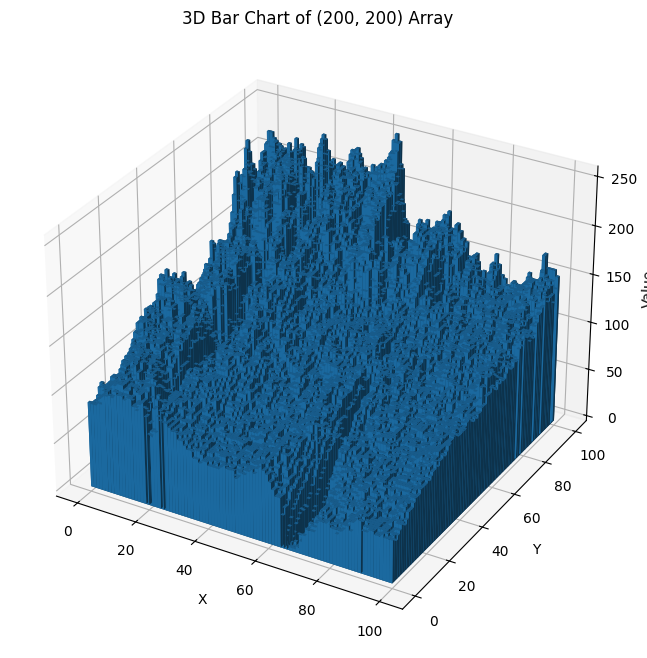

In [10]:
plot_barchartImage(Perspectiver.rgb_to_grayscale(original_image))

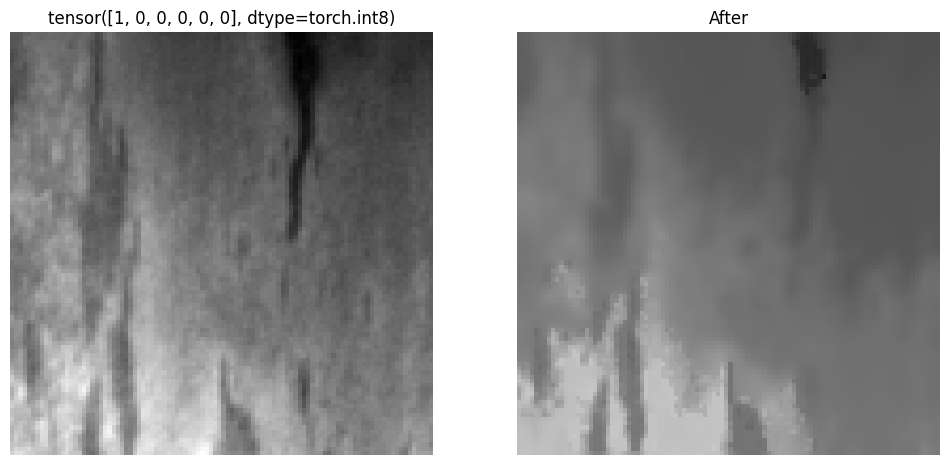

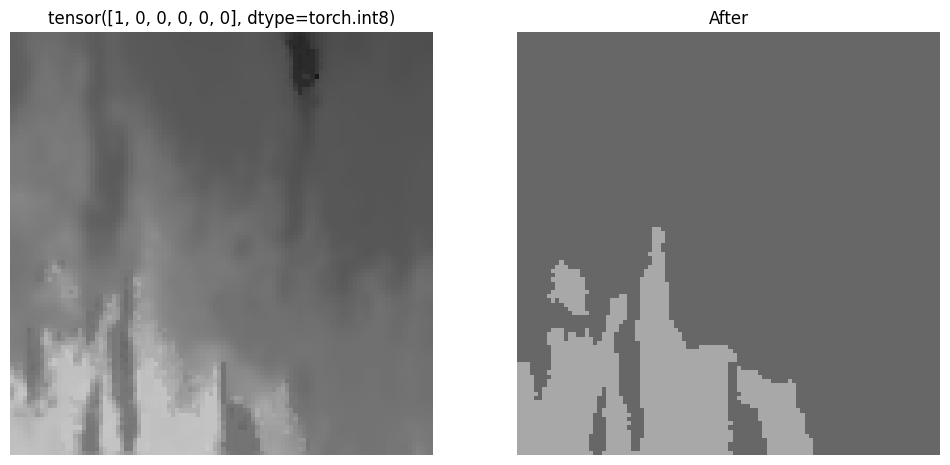

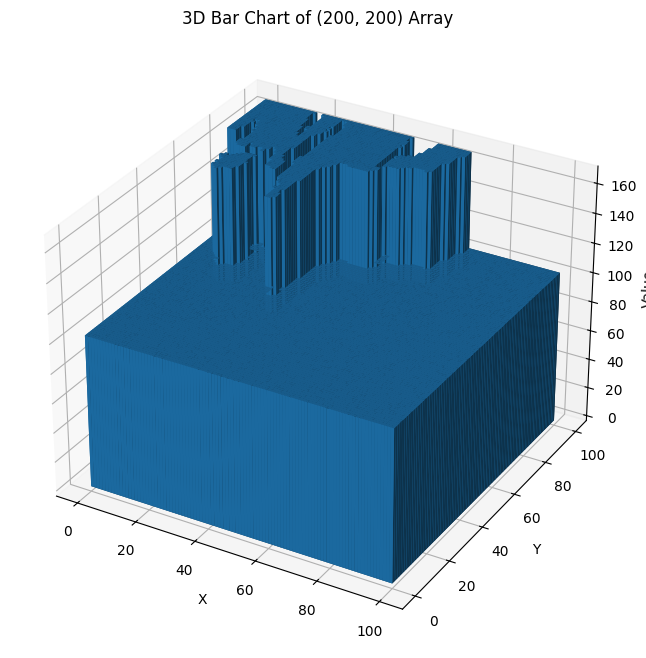

Real mean : 77.0
Optimized : 77.0


In [11]:
clustered_image = Perspectiver.meanShift(original_image, BEST["sp"], BEST["sr"])
#clustered_image = Perspectiver.meanShift(original_image, 5, 6)
Perspectiver.plotComparison(original_image, clustered_image, titleBefore=label)

kmeans_image = Perspectiver.kmeansClustering(clustered_image, k = BEST["k"])
#kmeans_image = Perspectiver.kmeansClustering(clustered_image, k = 7)
Perspectiver.plotComparison(clustered_image, kmeans_image, titleBefore=label)

plot_barchartImage(Perspectiver.rgb_to_grayscale(kmeans_image))
Perspectiver.evaluate_clustering(original_image, kmeans_image)
print("Real mean :", get_mean_pit_area(kmeans_image))
print("Optimized :", get_mean_pit_area_superfast(kmeans_image))

In [12]:
def transformar_matriz(matriz):
    """
    Transforma una matriz con valores en [0,255] a una de [0,127].
    Si el valor <= 127 se mantiene, y si > 127 se mapea linealmente:
    127 -> 127 y 255 -> 0.
    """
    # Convertir a flotante para cálculos precisos
    out = matriz.astype(np.float32).copy()
    # Crear máscara para los valores mayores que 127
    mask = out > 127
    # Aplicar transformación lineal a los valores superiores a 127
    out[mask] = 127 - (out[mask] - 127) * (127 / 128)
    # Redondear y convertir a entero sin signo (0-255)
    return np.round(out).astype(np.uint8)

def distancia_minima_vecinos(arr):
    """
    Calcula para cada elemento la distancia mínima al vecino inmediato.
    En los extremos se usa el único vecino.
    """
    arr = np.array(arr)
    n = arr.size
    if n < 2:
        return np.zeros_like(arr)
    
    # Diferencias absolutas entre elementos adyacentes.
    dif = np.abs(np.diff(arr))
    
    # Inicializar el resultado.
    res = np.empty(n, dtype=arr.dtype)
    res[0] = dif[0]       # Primer elemento: sólo tiene el vecino derecho.
    res[-1] = dif[-1]     # Último elemento: sólo tiene el vecino izquierdo.
    
    # Para los elementos intermedios, se toma el mínimo de la diferencia con el vecino izquierdo y derecho.
    res[1:-1] = np.minimum(dif[:-1], dif[1:])
    
    return res

def distance_vector(clusters):
    ret = []
    for i in range(len(clusters)):
        if i == 0: ret.append(np.abs(clusters[i]-clusters[i+1]))
        if i == (len(clusters) - 1): ret.append(np.abs(clusters[i]-clusters[i-1]))
        else: ret.append(min(np.abs(clusters[i]-clusters[i-1]), np.abs(clusters[i]-clusters[i+1])))
    return ret

def plot_zonas_picos(matriz, umbral=None):
    """
    Detecta zonas de cambios bruscos (picos) en una matriz 2D mediante la magnitud del gradiente.
    Plotea la matriz en escala de grises y marca en azul los puntos donde la magnitud del gradiente
    supera el umbral definido.
    
    Parámetros:
      matriz: array 2D de entrada.
      umbral: valor umbral para considerar un cambio brusco. Si es None, se usa 80% del máximo.
    """
    # Calcular gradiente en las direcciones y (filas) y x (columnas)
    grad_y, grad_x = np.gradient(matriz.astype(float))
    # Magnitud del gradiente
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    
    # Definir umbral: 80% del máximo de la magnitud, si no se proporciona uno
    if umbral is None:
        umbral = 0.2 * np.max(grad_mag)
    
    # Índices donde la magnitud del gradiente supera el umbral
    indices = np.nonzero(grad_mag > umbral)
    
    # Plotear la imagen y superponer los puntos con cambios bruscos en azul
    plt.figure(figsize=(8, 6))
    plt.imshow(matriz, cmap='gray')
    plt.scatter(indices[1], indices[0], s=80, facecolors='none', edgecolors='blue', label='Zona de picos')
    plt.title("Zonas de picos (cambios bruscos) en azul")
    plt.legend()
    plt.show()

def variacion_media(arr):
    media = sum(arr) / len(arr)
    return sum(abs(x - media) for x in arr) / len(arr)

def plotear_imagen(array2d):
    """
    Plotea un array 2D como imagen en escala de grises.
    """
    plt.imshow(array2d, cmap='gray')
    plt.colorbar()  # Barra de color para referencia de intensidades
    plt.title("Imagen 2D")
    plt.show()

In [13]:
import numpy as np
from collections import deque

def calcular_area_fosas(image):
    pixels = np.uint8(np.round(Perspectiver.rgb_to_grayscale(Perspectiver.normalize_to_uint8(image))))
    clusters = np.sort(np.unique(pixels))

    numero_de_fosas = 0
    area_de_fosas = 0

    registro_de_fosas = []

    directions = {"right": (1,0), "right": (-1,0), :(0,1), (0,-1)}

    MAXROW, MAXCOL = pixels.shape
    for cluster in clusters:

        print(f"Altura del cluster: {cluster}")
        
        rows, cols = np.where(pixels == cluster)
        positions = list(zip(rows, cols))

        print(positions)

        break

calcular_area_fosas(kmeans_image)

SyntaxError: invalid syntax (4128842075.py, line 13)

In [12]:
def anormal_ratio(image):
    pixels = np.uint8(np.round(Perspectiver.rgb_to_grayscale(Perspectiver.normalize_to_uint8(image))))
    print(f"Imagen entrante: \n {pixels}")
    #pixels = transformar_matriz(pixels)
    plotear_imagen(pixels)

    clusters = np.sort(np.unique(pixels))
    print(f"Clusters: {len(clusters)}, distribucion: \n {clusters} ")

    
    plot_zonas_picos(pixels)

In [ ]:
anormal_ratio(kmeans_image)